In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
import matplotlib.pyplot as plt
import numpy as np
from kdg.utils import plot_2dsim, gaussian_sparse_parity, generate_gaussian_parity
import tensorflow_addons as tfa

In [63]:
n_samples = 500
angle = 0
noise_dim = 2
num_classes = 2

X, y = generate_gaussian_parity(n_samples, angle_params=angle)
X_noise = np.random.uniform(
            low=-1, high=1, size=(n_samples, noise_dim)
        )
X = np.concatenate((X, X_noise), axis=1)

<AxesSubplot: >

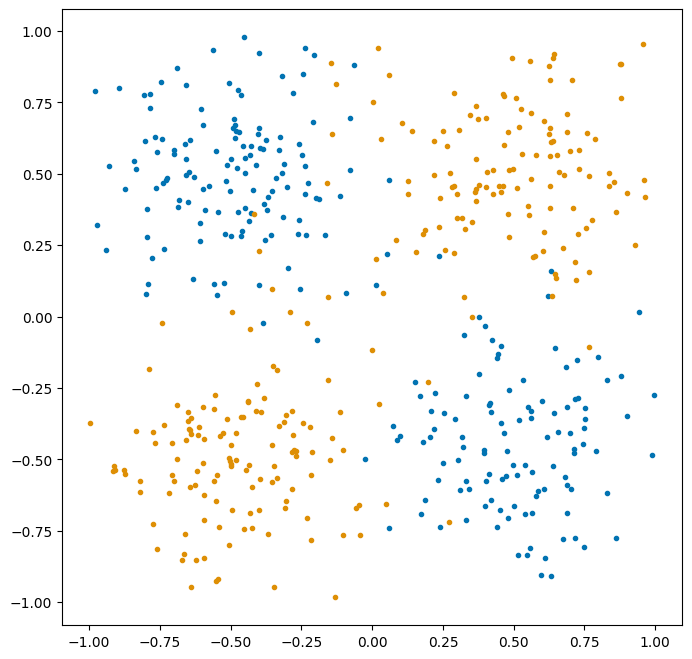

In [55]:
plot_2dsim(X[:,:2],y)

In [56]:
# class SupervisedContrastiveLoss(keras.losses.Loss):

#     def __call__(self, labels, feature_vectors, sample_weight=None):
#         # Normalize feature vectors
#         #print(feature_vectors)
#         # Compute logits
#         feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
#         logits = tf.matmul(
#                 feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
#             )
#         #print(logits, 'logits')
#         # normalized_logits = tf.divide(
#         #         logits,
#         #         tf.math.abs(logits)
#         # )

#         #print(normalized_logits)
#         labels_normalized = tf.math.l2_normalize(labels, axis=1)
#         logits_true = tf.matmul(
#                 labels_normalized, tf.transpose(labels_normalized)
#             )
#         # normalized_logits_true = tf.divide(
#         #         logits_true,
#         #         tf.abs(logits_true)
#         # )

#         loss = tf.reduce_sum(
#             tf.abs(
#                 tf.subtract(
#                     logits,
#                     logits_true
#                 )
#             )
#         )
        
#         return loss

class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [57]:
compile_kwargs = {
        "loss": SupervisedContrastiveLoss(),
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=100, verbose=True)
fit_kwargs = {
        "epochs": 500,
        "batch_size": 64,
        "verbose": True,
        "callbacks": [callback],
    }

In [58]:
# network architecture [1000, 1000, 1000, 1000, 2]
def getNN(input_size, latent_dim):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=latent_dim, kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [59]:
def task_head(latent_dim, num_classes):
    head = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    head.add(keras.layers.Dense(10, kernel_initializer=initializer, input_shape=(latent_dim,)))
    head.add(keras.layers.Activation(activations.relu))
    head.add(keras.layers.Dense(10, kernel_initializer=initializer))
    head.add(keras.layers.Activation(activations.relu))
    head.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    head.compile(**compile_kwargs_head)
    return head

In [60]:
encoder = getNN(input_size=X.shape[1], latent_dim=2)
history = encoder.fit(X, y, **fit_kwargs)

Epoch 1/500


2024-06-16 10:47:22.761881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'


8/8 [==============================] - 1s 27ms/step - loss: 4.1388
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 4.0976
Epoch 3/500
1/8 [==>...........................] - ETA: 0s - loss: 4.0338

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x52x1x1xi1>'


8/8 [==============================] - 0s 14ms/step - loss: 3.9173
Epoch 4/500
8/8 [==============================] - 0s 14ms/step - loss: 3.7943
Epoch 5/500
8/8 [==============================] - 0s 16ms/step - loss: 3.8838
Epoch 6/500
8/8 [==============================] - 0s 14ms/step - loss: 4.0685
Epoch 7/500
8/8 [==============================] - 0s 15ms/step - loss: 3.8795
Epoch 8/500
8/8 [==============================] - 0s 14ms/step - loss: 3.8475
Epoch 9/500
8/8 [==============================] - 0s 14ms/step - loss: 3.7684
Epoch 10/500
8/8 [==============================] - 0s 14ms/step - loss: 3.7399
Epoch 11/500
8/8 [==============================] - 0s 14ms/step - loss: 3.6956
Epoch 12/500
8/8 [==============================] - 0s 15ms/step - loss: 3.7156
Epoch 13/500
8/8 [==============================] - 0s 16ms/step - loss: 3.7363
Epoch 14/500
8/8 [==============================] - 0s 13ms/step - loss: 3.7207
Epoch 15/500
8/8 [==============================] - 0s 13ms

In [64]:
embedding = encoder.predict(X)

16/16 [==============================] - 0s 3ms/step


<AxesSubplot: >

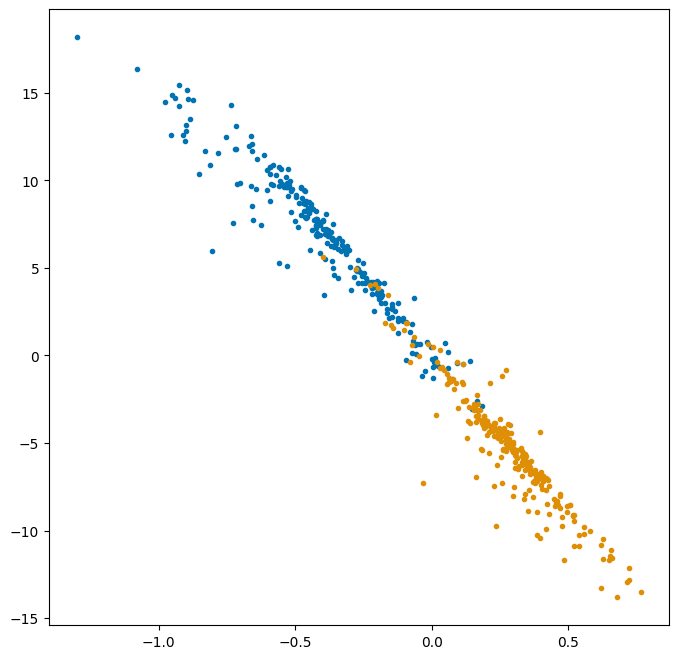

In [65]:
plot_2dsim(embedding, y)

In [14]:
compile_kwargs_head = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-3),
    }
callback_head = keras.callbacks.EarlyStopping(monitor="loss", patience=100, verbose=True)
fit_kwargs_head = {
        "epochs": 200,
        "batch_size": 32,
        "verbose": True,
        "callbacks": [callback_head],
    }

In [15]:
head1 = task_head(latent_dim=2, num_classes=num_classes)
history = head1.fit(embedding, keras.utils.to_categorical(y), **fit_kwargs_head)

Epoch 1/200
 1/16 [>.............................] - ETA: 4s - loss: 0.6929

2024-06-16 08:52:36.356354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

16/16 [==============================] - 0s 13ms/step - loss: 0.6886
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.6551
Epoch 3/200
 1/16 [>.............................] - ETA: 0s - loss: 0.6025

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

16/16 [==============================] - 0s 6ms/step - loss: 0.5561
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.4082
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2976
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2427
Epoch 7/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2257
Epoch 8/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2227
Epoch 9/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2212
Epoch 10/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2202
Epoch 11/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2184
Epoch 12/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2180
Epoch 13/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2167
Epoch 14/200
16/16 [==============================] - 0s 6ms/step - loss: 0.2171
Epoch 15/200
16/16 [===========================

In [47]:
prediction = head1.predict(embedding)

16/16 [==============================] - 0s 2ms/step


<AxesSubplot: >

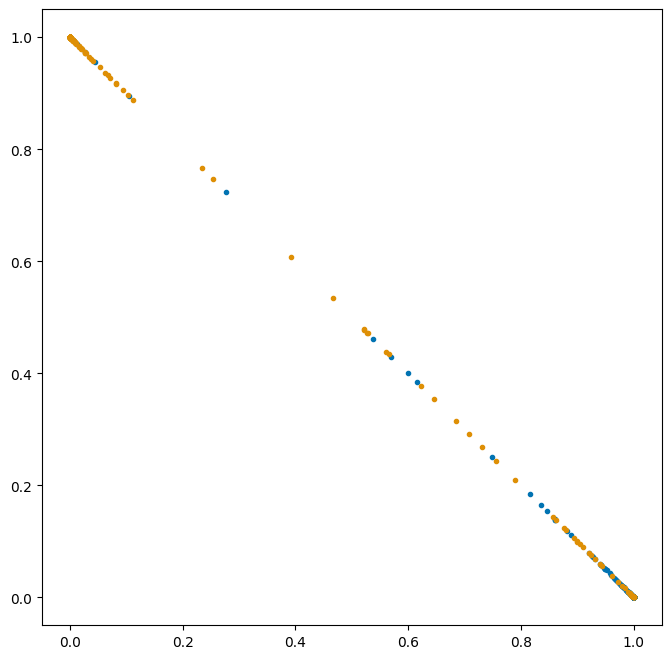

In [48]:
plot_2dsim(prediction, y)

In [49]:
np.sum(np.argmax(head1.predict(embedding),axis=1)==y)

16/16 [==============================] - 0s 2ms/step


435

In [39]:
n_samples = 500
angle = np.pi/6
noise_dim = 10
num_classes = 2

X2, y2 = generate_gaussian_parity(n_samples, angle_params=angle)
X_noise = np.random.uniform(
            low=-1, high=1, size=(n_samples, noise_dim)
        )
X2 = np.concatenate((X2, X_noise), axis=1)

<AxesSubplot: >

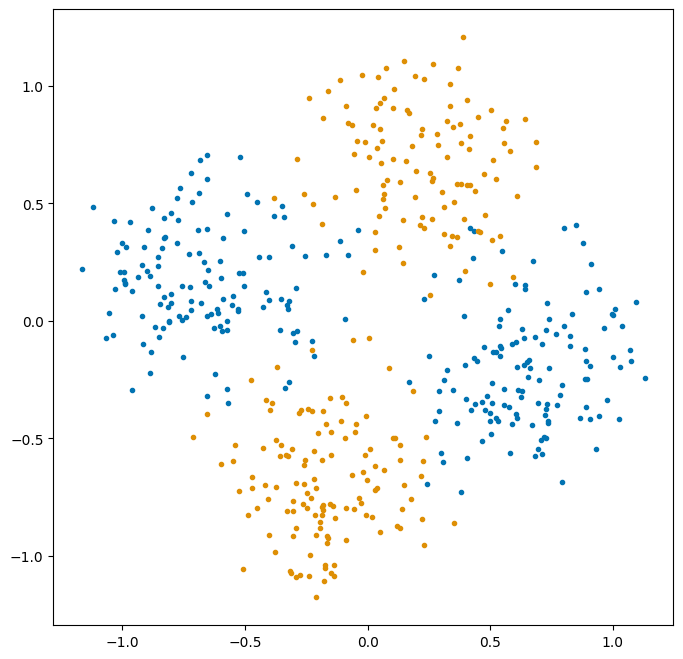

In [40]:
plot_2dsim(X2[:,:2],y2)

In [41]:
embedding = encoder.predict(X2)

16/16 [==============================] - 0s 3ms/step


<AxesSubplot: >

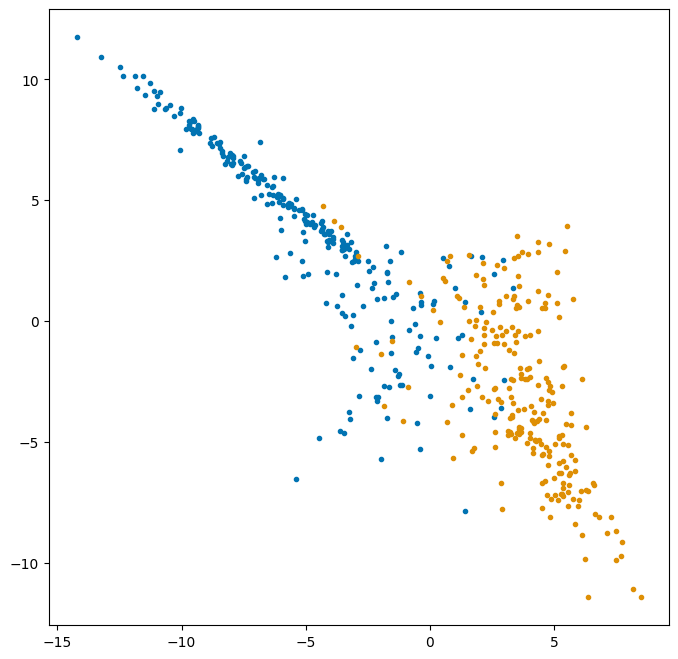

In [42]:
plot_2dsim(embedding, y2)

In [23]:
y2_label = np.argmax(head1.predict(embedding),axis=1)

16/16 [==============================] - 0s 3ms/step


In [24]:
# y2_combined = np.concatenate(
#         (keras.utils.to_categorical(y2_label),
#         keras.utils.to_categorical(y2)),
#         axis=1
#     )

y2_combined = y2_label*num_classes + y2
        

In [25]:
history = encoder.fit(X2, y2_combined, **fit_kwargs)

Epoch 1/500
8/8 [==============================] - 0s 13ms/step - loss: 3.8203
Epoch 2/500
8/8 [==============================] - 0s 13ms/step - loss: 3.8574
Epoch 3/500
8/8 [==============================] - 0s 13ms/step - loss: 3.7924
Epoch 4/500
8/8 [==============================] - 0s 13ms/step - loss: 3.7236
Epoch 5/500
8/8 [==============================] - 0s 13ms/step - loss: 3.6876
Epoch 6/500
8/8 [==============================] - 0s 13ms/step - loss: 3.6526
Epoch 7/500
8/8 [==============================] - 0s 12ms/step - loss: 3.6323
Epoch 8/500
8/8 [==============================] - 0s 12ms/step - loss: 3.6079
Epoch 9/500
8/8 [==============================] - 0s 13ms/step - loss: 3.6294
Epoch 10/500
8/8 [==============================] - 0s 13ms/step - loss: 3.6398
Epoch 11/500
8/8 [==============================] - 0s 13ms/step - loss: 3.6612
Epoch 12/500
8/8 [==============================] - 0s 13ms/step - loss: 3.6136
Epoch 13/500
8/8 [==============================]

In [26]:
embedding = encoder.predict(X2)

16/16 [==============================] - 0s 3ms/step


<AxesSubplot: >

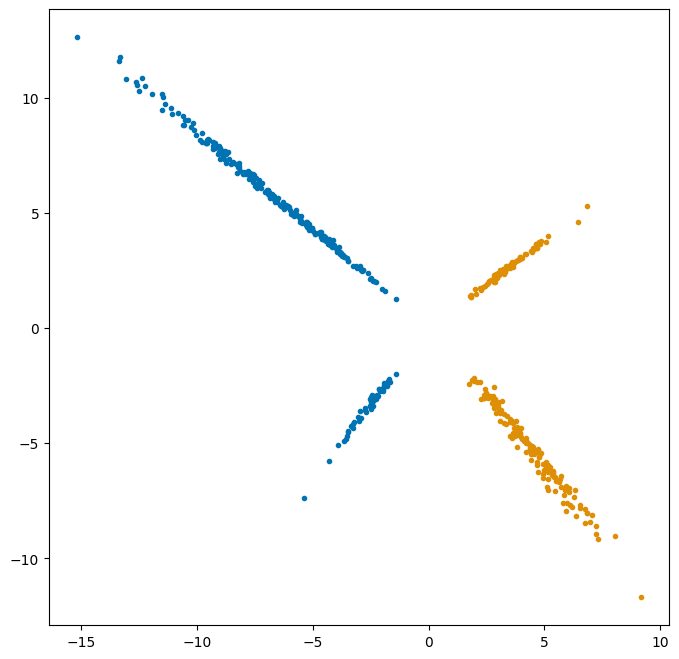

In [27]:
plot_2dsim(embedding, y2)

In [28]:
head2 = task_head(latent_dim=2, num_classes=num_classes)
history = head2.fit(embedding, keras.utils.to_categorical(y2), **fit_kwargs_head)

Epoch 1/200
 1/16 [>.............................] - ETA: 3s - loss: 0.6923

2024-06-16 08:54:17.317556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

16/16 [==============================] - 0s 12ms/step - loss: 0.5047
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0529
Epoch 3/200
 1/16 [>.............................] - ETA: 0s - loss: 0.0060

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

16/16 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 4.0819e-04
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 2.8653e-04
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: 2.4841e-04
Epoch 7/200
16/16 [==============================] - 0s 6ms/step - loss: 2.2793e-04
Epoch 8/200
16/16 [==============================] - 0s 6ms/step - loss: 2.1061e-04
Epoch 9/200
16/16 [==============================] - 0s 6ms/step - loss: 1.9610e-04
Epoch 10/200
16/16 [==============================] - 0s 6ms/step - loss: 1.8399e-04
Epoch 11/200
16/16 [==============================] - 0s 6ms/step - loss: 1.7288e-04
Epoch 12/200
16/16 [==============================] - 0s 6ms/step - loss: 1.6314e-04
Epoch 13/200
16/16 [==============================] - 0s 6ms/step - loss: 1.5417e-04
Epoch 14/200
16/16 [==============================] - 0s 6ms/step - loss: 1.4623e-04
Epo

In [36]:
prediction = head2.predict(embedding)

16/16 [==============================] - 0s 2ms/step


<AxesSubplot: >

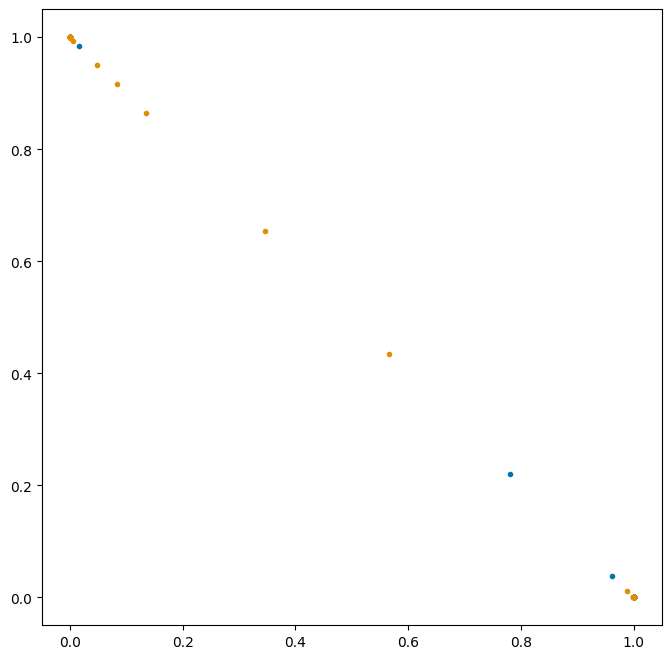

In [37]:
plot_2dsim(prediction, y2)

In [38]:
np.sum(np.argmax(head2.predict(embedding),axis=1)==y2)

16/16 [==============================] - 0s 2ms/step


468

In [50]:
n_samples = 500
angle = np.pi/4
noise_dim = 10
num_classes = 2

X3, y3 = generate_gaussian_parity(n_samples, angle_params=angle)
X_noise = np.random.uniform(
            low=-1, high=1, size=(n_samples, noise_dim)
        )
X3 = np.concatenate((X3, X_noise), axis=1)

<AxesSubplot: >

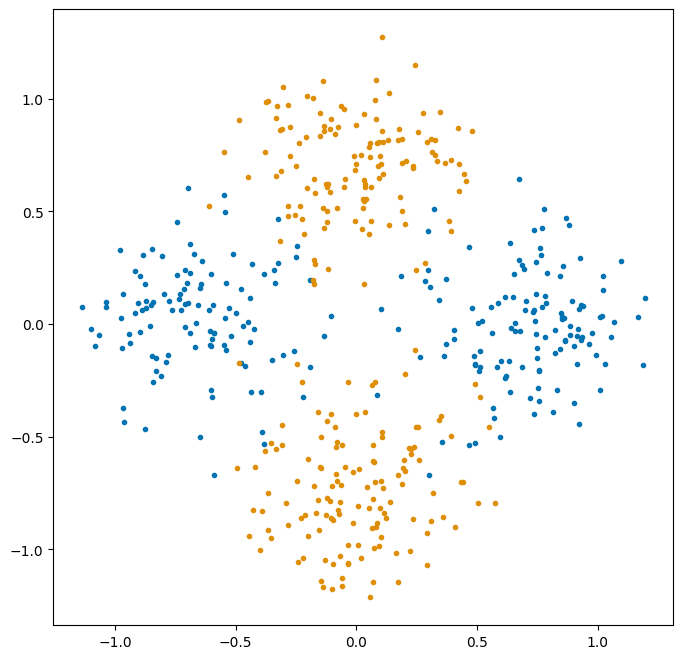

In [51]:
plot_2dsim(X3[:,:2],y3)

In [52]:
embedding = encoder.predict(X3)

16/16 [==============================] - 0s 3ms/step


<AxesSubplot: >

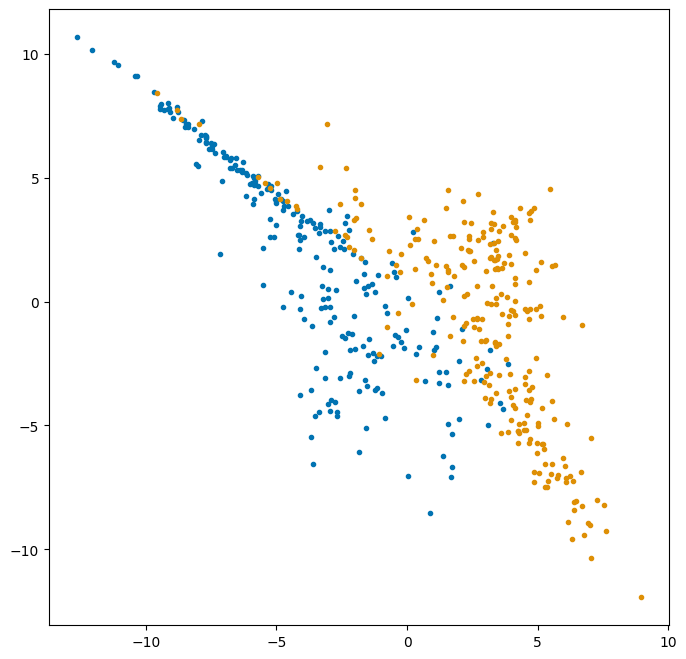

In [53]:
plot_2dsim(embedding, y3)

In [73]:
y3_label1 = np.argmax(head1.predict(embedding),axis=1)
y3_label2 = np.argmax(head2.predict(embedding),axis=1)

16/16 [==============================] - 0s 2ms/step


In [74]:
y3_combined = y3_label1*2**2 + y3_label2*2 + y3

In [75]:
y3_combined

array([6, 6, 0, 6, 6, 6, 2, 6, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 2, 6, 2, 0,
       0, 0, 0, 2, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0,
       6, 2, 0, 0, 6, 0, 6, 6, 0, 0, 6, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 6,
       0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 6, 6,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 6, 6,
       0, 0, 0, 6, 0, 0, 2, 0, 6, 0, 0, 0, 1, 3, 7, 1, 3, 3, 1, 7, 7, 7,
       7, 7, 3, 3, 1, 3, 3, 7, 3, 1, 7, 7, 7, 3, 3, 1, 7, 3, 7, 7, 7, 7,
       3, 7, 1, 7, 1, 1, 1, 3, 7, 7, 3, 7, 7, 3, 7, 7, 3, 1, 1, 1, 7, 1,
       7, 7, 1, 7, 7, 3, 7, 1, 3, 1, 7, 7, 1, 1, 1, 7, 7, 7, 1, 7, 1, 1,
       7, 7, 1, 1, 1, 7, 7, 7, 1, 7, 7, 7, 1, 7, 7, 1, 7, 7, 3, 7, 1, 7,
       7, 1, 7, 3, 7, 1, 3, 7, 7, 7, 7, 7, 3, 7, 7, 1, 7, 1, 7, 1, 7, 7,
       1, 7, 7, 7, 7, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 1,
       7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 3, 1, 1, 7, 7, 1, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 1,

In [76]:
history = encoder.fit(X3, y3_combined, **fit_kwargs)

Epoch 1/500
8/8 [==============================] - 0s 13ms/step - loss: 3.7100
Epoch 2/500
8/8 [==============================] - 0s 13ms/step - loss: 3.7635
Epoch 3/500
8/8 [==============================] - 0s 13ms/step - loss: 3.7315
Epoch 4/500
8/8 [==============================] - 0s 13ms/step - loss: 3.7127
Epoch 5/500
8/8 [==============================] - 0s 13ms/step - loss: 3.7210
Epoch 6/500
8/8 [==============================] - 0s 13ms/step - loss: 3.7059
Epoch 7/500
8/8 [==============================] - 0s 13ms/step - loss: 3.6855
Epoch 8/500
8/8 [==============================] - 0s 13ms/step - loss: 3.6850
Epoch 9/500
8/8 [==============================] - 0s 13ms/step - loss: 3.6889
Epoch 10/500
8/8 [==============================] - 0s 14ms/step - loss: 3.6492
Epoch 11/500
8/8 [==============================] - 0s 15ms/step - loss: 3.6613
Epoch 12/500
8/8 [==============================] - 0s 16ms/step - loss: 3.6600
Epoch 13/500
8/8 [==============================]

In [77]:
embedding = encoder.predict(X3)

16/16 [==============================] - 0s 2ms/step


<AxesSubplot: >

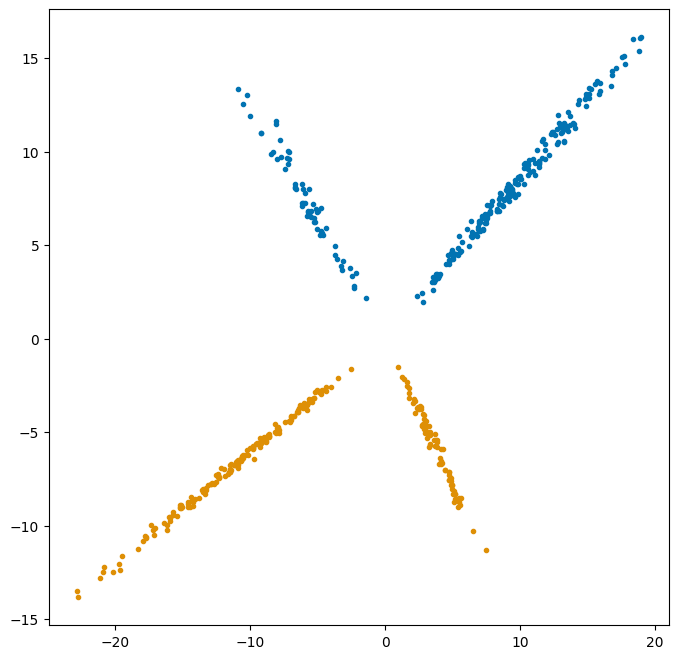

In [78]:
plot_2dsim(embedding, y3)

In [79]:
head3 = task_head(latent_dim=2, num_classes=num_classes)
history = head3.fit(embedding, keras.utils.to_categorical(y3), **fit_kwargs_head)

Epoch 1/200
 1/16 [>.............................] - ETA: 3s - loss: 0.6939

2024-06-15 19:19:22.964237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

16/16 [==============================] - 0s 13ms/step - loss: 0.4797
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0410
Epoch 3/200


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

16/16 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 8.6464e-04
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 5.6151e-04
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: 4.7308e-04
Epoch 7/200
16/16 [==============================] - 0s 6ms/step - loss: 4.1416e-04
Epoch 8/200
16/16 [==============================] - 0s 8ms/step - loss: 3.7119e-04
Epoch 9/200
16/16 [==============================] - 0s 6ms/step - loss: 3.3831e-04
Epoch 10/200
16/16 [==============================] - 0s 6ms/step - loss: 3.0734e-04
Epoch 11/200
16/16 [==============================] - 0s 6ms/step - loss: 2.8452e-04
Epoch 12/200
16/16 [==============================] - 0s 6ms/step - loss: 2.6297e-04
Epoch 13/200
16/16 [==============================] - 0s 6ms/step - loss: 2.4327e-04
Epoch 14/200
16/16 [==============================] - 0s 6ms/step - loss: 2.2795e-04
Epo

In [80]:
np.sum(np.argmax(head3.predict(embedding),axis=1)==y3)

16/16 [==============================] - 0s 4ms/step


2024-06-15 19:19:44.759474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500